# Training and evaluation notebook

In [1]:
## imports
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

## 1. Construct dataset

In [2]:
# Simply reading the formerly created pickle file, changing it's name to 'merged_df'
# To confirm, you can load and view the combined dataset
with open("combined_dataset.pkl", 'rb') as file:
    merged_df = pd.read_pickle(file)

merged_df


,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,class
0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2
1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2
2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2
3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2
4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2
1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2
1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2
1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2


## 2. Add indices

In [3]:
merged_df['NDVI'] = (merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + merged_df['B4'])

# EVI is an optimized vegetation index designed to enhance the vegetation signal with improved sensitivity in high biomass regions
# It's calculated using the Red (B4), Near-Infrared (B8 or B5), and Blue (B2) bands.
merged_df['EVI'] = 2.5 * (merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + 6 * merged_df['B4'] - 7.5 * merged_df['B2'] + 1)

# NDWI is used to monitor changes in water content of leaves
# It is typically calculated using the Near-Infrared (B8 or B5) and Short-Wave Infrared (B11 or B6) bands.
merged_df['NDWI'] = (merged_df['B8'] - merged_df['B11']) / (merged_df['B8'] + merged_df['B11'])

# SAVI is a modification of NDVI to correct for the influence of soil brightness
# The standard value of L in the SAVI formula is 0.5.
L = 0.5  # soil brightness correction factor
merged_df['SAVI'] = ((merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + merged_df['B4'] + L)) * (1 + L)

# GNDVI is used to estimate vegetation health
# It's calculated using the Near-Infrared (B8 or B5) and Green (B3) bands.
merged_df['GNDVI'] = (merged_df['B8'] - merged_df['B3']) / (merged_df['B8'] + merged_df['B3'])

merged_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,class,NDVI,EVI,NDWI,SAVI,GNDVI
0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2,0.568914,0.246737,-0.052386,0.271183,0.670018
1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2,0.581259,0.287926,-0.015721,0.308070,0.688819
2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2,0.834221,0.731688,0.337125,0.652436,0.765506
3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2,0.776236,0.581962,0.247564,0.544852,0.721622
4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2,0.830017,0.746039,0.372873,0.664865,0.767403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2,0.516930,0.319632,-0.031002,0.321629,0.602862
1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2,0.625818,0.443384,0.076328,0.432730,0.637691
1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2,0.484021,0.294097,-0.044519,0.296020,0.571209
1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2,0.602697,0.397850,0.009969,0.393631,0.653291


In [50]:
# Export the DataFrame to a CSV file
merged_df.to_csv('merged_df.csv', index=True)  # Adjust the filename as needed

### collapsing locations

In [51]:
# Assuming 'merged_df' is your pandas DataFrame
merged_df = merged_df.drop('sample_location_id', axis=1)

## 4. Constructing stratified K-fold cross validation (SKF)

Stratified just means you're trying to ensure each fold has the same relative proportion of each class so that you're training and testing on the same proportion of data for each K-fold. 



The purpose of the cell below is to find the optimal number of folds which are either individual locations or groupings of individual locations so that the relative class proportions across all folds are as balanced as possible

It's meant to save you from staring at the class distributions per location and trying to manually come up with the folds yourself. 

In [52]:
# renaming 'class' column to 'classes' to fix python error
merged_df = merged_df.rename(columns={'class': 'classes'})

0 = actively eroding,
1 = drained, 
2 = modified, 
3 = bare peat, 
4 = restored, 

In [53]:
# Assuming merged_df is your pandas DataFrame
# Shuffle the DataFrame using a random seed, for example, seed=42
shuffled_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,classes,NDVI,EVI,NDWI,SAVI,GNDVI
0,0.0314,0.04940,0.07090,0.08650,0.13200,0.21270,0.24250,0.27180,0.2772,0.27020,0.31170,0.17690,1,0.517164,0.326164,-0.068380,0.323838,0.586227
1,0.0276,0.02810,0.06120,0.03640,0.10860,0.35290,0.45100,0.47480,0.4947,0.46610,0.23810,0.10850,4,0.857590,0.739317,0.332024,0.650316,0.771642
2,0.0430,0.05670,0.07940,0.10090,0.14685,0.21885,0.25335,0.28550,0.2913,0.29245,0.30345,0.18250,1,0.477743,0.314877,-0.030478,0.312387,0.564812
3,0.0383,0.03930,0.06020,0.06860,0.12090,0.26350,0.29060,0.31320,0.3408,0.33520,0.24780,0.13710,4,0.640650,0.427607,0.116578,0.416081,0.677558
4,0.0186,0.03150,0.05255,0.05850,0.10105,0.18555,0.21140,0.26230,0.2496,0.26135,0.23120,0.14775,3,0.635287,0.369994,0.063019,0.372442,0.666190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152805,0.0294,0.03410,0.04840,0.05670,0.10300,0.18860,0.21890,0.23350,0.2488,0.25060,0.22140,0.11940,1,0.609235,0.335369,0.026599,0.335611,0.656616
1152806,0.0273,0.03210,0.04950,0.04860,0.09730,0.20170,0.24280,0.27270,0.2738,0.29780,0.18320,0.08830,1,0.697479,0.423293,0.196315,0.409290,0.692737
1152807,0.0343,0.03675,0.05535,0.06445,0.13925,0.19975,0.22960,0.23735,0.2646,0.26345,0.26630,0.15395,2,0.572896,0.320559,-0.057480,0.323460,0.621797
1152808,0.0319,0.03150,0.05790,0.05620,0.11530,0.22010,0.25380,0.29080,0.2940,0.31660,0.23070,0.11430,1,0.676081,0.421412,0.115245,0.415466,0.667909


## 4. constructing training and test sets

In [54]:
from sklearn.model_selection import train_test_split

# Assuming your features are all columns except 'classes', and 'classes' is the target variable
X = shuffled_df.drop('classes', axis=1)  # Features
y = shuffled_df['classes']  # Target variable

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train and y_train will now contain 70% of the data, X_test and y_test will contain 30%

In [55]:
# Save X_train to a CSV file
X_train.to_csv('X_train.csv', index=False)

# Save X_test to a CSV file
X_test.to_csv('X_test.csv', index=False)

# Save y_train to a CSV file
# Since y_train is a Series, we convert it to a DataFrame for consistency
y_train.to_frame().to_csv('y_train.csv', index=False)

# Save y_test to a CSV file
# Since y_test is a Series, we convert it to a DataFrame for consistency
y_test.to_frame().to_csv('y_test.csv', index=False)

Optuna on train and test dataset

In [61]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    
    
    # Initialize the classifier with the current hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Predict on the validation set
    predictions = clf.predict(X_test)
    
    # Compute and return the accuracy
    accuracy = accuracy_score(y_test, predictions)
    return accuracy


In [63]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Adjust the number of trials as needed

print(f"Best trial: {study.best_trial.params}")


[I 2024-02-11 22:44:11,774] A new study created in memory with name: no-name-80c97423-6fb3-4a7f-8e8e-211730445a2b


[I 2024-02-11 22:45:01,029] Trial 0 finished with value: 0.4287870507715929 and parameters: {'n_estimators': 291, 'max_depth': 2, 'min_samples_split': 0.4633394932831646, 'min_samples_leaf': 0.41898194416292645}. Best is trial 0 with value: 0.4287870507715929.


## 5. training / evaluating 

start with a baseline model, the simplest possible model, using logistic regression on the SKF you sorted out above. This establishes your baseline. 

Found out that there were NaN values in dataset, but only three, so I first remove them below:

In [8]:
# Check for any NaN values in the DataFrame
nan_exists = merged_df.isnull().values.any()

# Print result
print(f"Are there any NaN values in the DataFrame? {nan_exists}")

Are there any NaN values in the DataFrame? True


In [9]:
# Get the count of NaNs in each column
nan_counts = merged_df.isnull().sum()

# Print columns with NaN counts greater than 0
print(nan_counts[nan_counts > 0])

NDVI     1
NDWI     1
GNDVI    1
dtype: int64


In [10]:
merged_df = merged_df.dropna()

Here is the logistic regression model:

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare features (X) and target (y)
features = merged_df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI']].values
target = merged_df['classes'].values

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=42)  # best_k determined from your previous code

accuracy_scores = []
scaler = StandardScaler()

for train_index, test_index in skf.split(features, target):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = target[train_index], target[test_index]

    # Scale the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Logistic Regression Model with increased max_iter and adjusted C
    model = LogisticRegression(max_iter=5000, C=10)
    model.fit(X_train_scaled, y_train)

    # Predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the Model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

average_accuracy = np.mean(accuracy_scores)
print(f"Average Accuracy across all folds: {average_accuracy}")

Average Accuracy across all folds: 0.4983813464491113


And here are some additional assessments as to how it performed:

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_test and y_pred are already defined from your previous code

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='macro')  # 'macro' averages over classes
recall = recall_score(y_test, y_pred, average='macro')  # 'macro' averages over classes
f1 = f1_score(y_test, y_pred, average='macro')  # 'macro' averages over classes

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.49395725555568754
Recall: 0.4069454829655209
F1 Score: 0.3931784864288107


Lastly an RF model across all features, that is, bands and VIs inclusive:

In [20]:
# features = merged_df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI']].values
# target = merged_df['classes'].values

# # Assuming features and target are already defined
# skf = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=42)

# rf_all_accuracy_scores = []
# rf_all_precision_scores = []
# rf_all_recall_scores = []
# rf_all_f1_scores = []

# for train_index, test_index in skf.split(features, target):
#     rf_all_X_train, rf_all_X_test = features[train_index], features[test_index]
#     rf_all_y_train, rf_all_y_test = target[train_index], target[test_index]

#     rf_all_model = RandomForestClassifier(n_estimators=100, random_state=42)
#     rf_all_model.fit(rf_all_X_train, rf_all_y_train)

#     rf_all_y_pred = rf_all_model.predict(rf_all_X_test)

#     rf_all_accuracy_scores.append(accuracy_score(rf_all_y_test, rf_all_y_pred))
#     rf_all_precision_scores.append(precision_score(rf_all_y_test, rf_all_y_pred, average='macro'))
#     rf_all_recall_scores.append(recall_score(rf_all_y_test, rf_all_y_pred, average='macro'))
#     rf_all_f1_scores.append(f1_score(rf_all_y_test, rf_all_y_pred, average='macro'))

# # Calculate the average scores across all folds
# rf_all_average_accuracy = np.mean(rf_all_accuracy_scores)
# rf_all_average_precision = np.mean(rf_all_precision_scores)
# rf_all_average_recall = np.mean(rf_all_recall_scores)
# rf_all_average_f1 = np.mean(rf_all_f1_scores)

# print(f"RF Bands and VIs Average Accuracy: {rf_all_average_accuracy}")
# print(f"RF Bands and VIs Average Precision: {rf_all_average_precision}")
# print(f"RF Bands and VIs Average Recall: {rf_all_average_recall}")
# print(f"RF Bands and VIs Average F1 Score: {rf_all_average_f1}")

RF Bands and VIs Average Accuracy: 0.7909941794398037
RF Bands and VIs Average Precision: 0.8228059357534965
RF Bands and VIs Average Recall: 0.7477214027472262
RF Bands and VIs Average F1 Score: 0.7767133766215912


Feature importance for RF all:

In [37]:
# Assuming X_train and y_train are your training data and labels
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(rf_all_X_train, rf_all_y_train)

# Get feature importance
importances = clf.feature_importances_

# Print the feature importances
print("Feature Importances:", importances)


Feature Importances: [0.10656363 0.06256748 0.04295264 0.05107344 0.06812389 0.05333279
 0.05057216 0.03411956 0.04960241 0.08781716 0.07903299 0.08170818
 0.04654216 0.04809754 0.04860802 0.04090257 0.0483834 ]


In [38]:
# Assuming you have a list of feature names corresponding to the order of features provided to the model
feature_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI']

# Mapping feature importance scores to their corresponding feature names
importances = clf.feature_importances_
feature_importance_dict = dict(zip(feature_names, importances))

# Printing feature importances in a more interpretable way
for feature, importance in sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True):
    print(f"{feature}: {importance}")


B1: 0.10656363173606073
B9: 0.0878171613488721
B12: 0.08170817956227323
B11: 0.0790329869247652
B5: 0.06812388761845203
B2: 0.06256747539785273
B6: 0.053332786586987375
B4: 0.051073438109255485
B7: 0.05057215880142362
B8A: 0.04960240645138941
NDWI: 0.04860801975760083
GNDVI: 0.04838339825625264
EVI: 0.048097543857085985
NDVI: 0.046542156064613066
B3: 0.042952637654631226
SAVI: 0.04090256894677449
B8: 0.034119562925709966


Feature importance for RF bands:

In [39]:
# Assuming X_train and y_train are your training data and labels
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(rf_bands_X_train, rf_bands_y_train)

# Get feature importance
importances_bands = clf.feature_importances_

# Print the feature importances
print("Bands Feature Importances:", importances_bands)

Bands Feature Importances: [0.12299149 0.07357307 0.05953855 0.07845013 0.08501202 0.07200014
 0.06934583 0.05797456 0.06859535 0.10872497 0.1013323  0.10246157]


In [40]:
# Assuming you have a list of feature names corresponding to the order of features provided to the model
feature_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

# Mapping feature importance scores to their corresponding feature names
importances_bands = clf.feature_importances_
feature_importance_dict = dict(zip(feature_names, importances_bands))

# Printing feature importances in a more interpretable way
for feature, importance in sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True):
    print(f"{feature}: {importance}")


B1: 0.1229914859884394
B9: 0.10872496941456683
B12: 0.10246157464367561
B11: 0.10133230009645854
B5: 0.08501202469588465
B4: 0.07845012851143043
B2: 0.07357307346374911
B6: 0.07200014413815138
B7: 0.06934583148255291
B8A: 0.06859535119362262
B3: 0.05953855188359311
B8: 0.05797456448787542


Suppose you want to find the best hyperparameter setting for your models:

you could use something like OPtuna and do it below, using k-fold cross validation, using the k and location splits above

In [12]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

features = merged_df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI']].values
target = merged_df['classes'].values

# Assuming 'best_k' is defined based on your previous analysis
# Assuming 'features' and 'target' are already defined as per your dataset

def objective(trial):
    # Hyperparameters to be optimized
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 16)
    
    # Initialize the RandomForestClassifier with suggested hyperparameters
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                 min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                 random_state=42)
    
    # Create StratifiedKFold object with 'best_k' folds
    skf = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=42)
    
    # Use cross-validation to evaluate model performance, passing the SKF object
    scores = cross_val_score(clf, features, target, cv=skf, scoring='accuracy')
    
    # Return the average of the cross-validation scores
    return np.mean(scores)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Adjust n_trials based on your computational budget

# Print the best hyperparameters found
print('Best trial:', study.best_trial.params)



[I 2024-02-06 16:30:34,756] A new study created in memory with name: no-name-ec237593-d786-459a-9102-acc553e9c459
[I 2024-02-06 16:43:54,766] Trial 0 finished with value: 0.5072605199469123 and parameters: {'n_estimators': 159, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.5072605199469123.
[I 2024-02-06 17:03:12,775] Trial 1 finished with value: 0.49176967583556697 and parameters: {'n_estimators': 255, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.5072605199469123.
[I 2024-02-06 17:05:15,888] Trial 2 finished with value: 0.4792107979632376 and parameters: {'n_estimators': 44, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.5072605199469123.
[I 2024-02-06 17:28:50,791] Trial 3 finished with value: 0.5445893078651296 and parameters: {'n_estimators': 194, 'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 10}. Best is trial 3 with val

Best trial: {'n_estimators': 276, 'max_depth': 32, 'min_samples_split': 12, 'min_samples_leaf': 1}


You have your final model(s) and you can evaluate them in the cell below:

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming features (X) and target (y) are already defined based on your dataset
X = merged_df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI']]
y = merged_df['classes']

# Optimal parameters from hyperparameter optimization
optimal_params = {
    'n_estimators': 276,
    'max_depth': 32,
    'min_samples_split': 12,
    'min_samples_leaf': 1,
    'random_state': 42  # Ensuring reproducibility
}

# Initialize the StratifiedKFold object
n_splits = best_k  # Assuming best_k is defined based on your previous code
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
precision_list = []
recall_list = []
accuracy_list = []
f1_list = []  # If you want to calculate F1 score as well

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Instantiate the RandomForestClassifier with the optimal parameters
    classifier = RandomForestClassifier(**optimal_params)

    # Train the classifier on the training set
    classifier.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = classifier.predict(X_test)

    # Calculate and append the evaluation metrics for the current fold
    precision_list.append(precision_score(y_test, y_pred, average='weighted'))
    recall_list.append(recall_score(y_test, y_pred, average='weighted'))
    accuracy_list.append(accuracy_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred, average='weighted'))  # Calculate F1 score

# Calculate average metrics across all folds
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_accuracy = np.mean(accuracy_list)
average_f1 = np.mean(f1_list)  # Average F1 score

# Print the average metrics
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average Accuracy: {average_accuracy}")
print(f"Average F1 Score: {average_f1}")


Average Precision: 0.7711323169751445
Average Recall: 0.7672747460552909
Average Accuracy: 0.7672747460552909
Average F1 Score: 0.755905179045945


- You'll also want to output an aggregated prediction confusion matrix (from the cross-validation), preferably as a seaborn (sns) figure. 

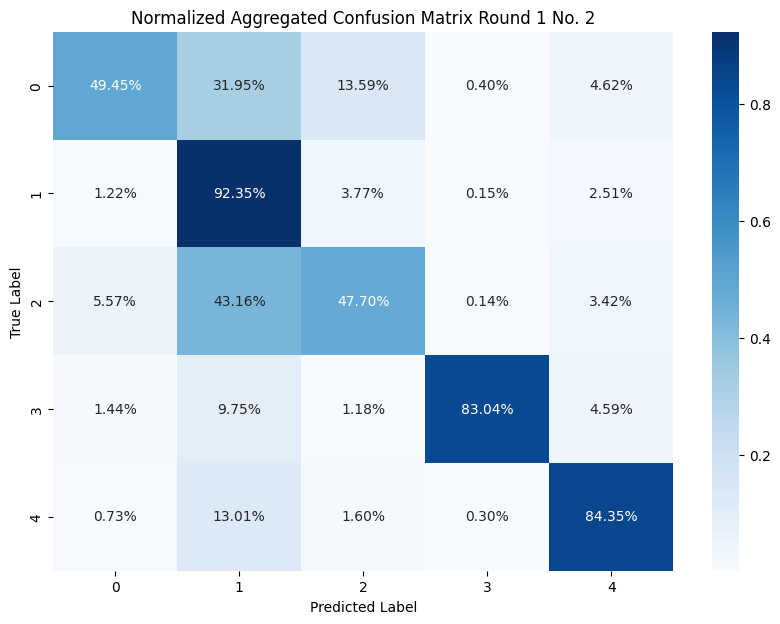

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X, y, skf.split, and optimal_params are already defined

# Initialize lists to collect true and predicted labels
true_labels = []
predicted_labels = []

# Your cross-validation and model training process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    classifier = RandomForestClassifier(**optimal_params)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Collect true and predicted labels
    true_labels.extend(y_test)
    predicted_labels.extend(y_pred)

# Compute the confusion matrix with normalization
cm_normalized = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Visualize the normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Normalized Aggregated Confusion Matrix Round 1 No. 2')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Feature permutation importance

In [17]:
## run feature permutation importance here. 
## Gives you an indication of which features are the most important for good classification performance
from sklearn.inspection import permutation_importance

# Perform permutation importance
result = permutation_importance(classifier, X, y, n_repeats=5, random_state=42, n_jobs=-1)

# Get the importance of each feature
feature_importance = result.importances_mean

# Optionally, sort the features by importance
sorted_idx = feature_importance.argsort()

# Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()



BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

kappa_list = []
kappa_list.append(cohen_kappa_score(y_test, y_pred))  # Calculate Cohen's Kappa score
average_kappa = np.mean(kappa_list)  # Average Cohen's Kappa score
print(f"Average Kappa Score: {average_kappa}")  # Print Average Cohen's Kappa Score

Average Kappa Score: 0.6609883583861486
